In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt

# 覆盖全局配置里的 SimHei，改成你系统里有的字体
plt.rcParams['font.sans-serif'] = ['DejaVu Sans','Arial']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
filename = 'vegetable_prices.csv'
df = pd.read_csv(filename)

In [4]:
df.head()

,period,vegetable,price,date
0,7149,韭菜,1.8,2025年3月31日
1,7149,四月蔓,1.0,2025年3月31日
2,7149,瓠子,2.3,2025年3月31日
3,7149,铁棍山药,3.5,2025年3月31日
4,7149,水芹菜,3.5,2025年3月31日


In [5]:
df = df.dropna()

# 重置一下索引（好看一点）
df = df.reset_index(drop=True)

In [6]:
# 先转换日期，出错的强制为 NaT
df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日', errors='coerce')

# 删除日期是 NaT 的行
df = df.dropna(subset=['date']).reset_index(drop=True)

# 提取时间特征
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# 确保价格是数值型
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# 最后检查一下有没有其他空的（比如价格）
print(df.isnull().sum())


period       0
vegetable    0
price        0
date         0
year         0
month        0
day          0
dtype: int64


In [7]:
df.head()

,period,vegetable,price,date,year,month,day
0,7149,韭菜,1.8,2025-03-31,2025,3,31
1,7149,四月蔓,1.0,2025-03-31,2025,3,31
2,7149,瓠子,2.3,2025-03-31,2025,3,31
3,7149,铁棍山药,3.5,2025-03-31,2025,3,31
4,7149,水芹菜,3.5,2025-03-31,2025,3,31


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


In [9]:
import matplotlib
print(matplotlib.matplotlib_fname())

/Users/fengyuanliu/anaconda3/envs/pytorch/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


# 土豆

In [10]:
# 先处理数据
df_potato = df[df['vegetable'] == '土豆'].copy()
df_potato = df_potato.sort_values('date').reset_index(drop=True)

# 加特征
df_potato['days_since_start'] = (df_potato['date'] - df_potato['date'].min()).dt.days
df_potato['sin_month'] = np.sin(2 * np.pi * df_potato['month'] / 12)
df_potato['cos_month'] = np.cos(2 * np.pi * df_potato['month'] / 12)

# 建模
X = df_potato[['days_since_start', 'sin_month', 'cos_month']]
y = df_potato['price']

model = LinearRegression()
model.fit(X, y)

# 预测整体
df_potato['price_pred'] = model.predict(X)

# 预测长期趋势部分（只用 days_since_start）
trend_model = LinearRegression()
trend_model.fit(df_potato[['days_since_start']], y)
df_potato['trend_part'] = trend_model.predict(df_potato[['days_since_start']])

# 预测季节性变化部分（只用 sin_month 和 cos_month）
season_model = LinearRegression()
season_model.fit(df_potato[['sin_month', 'cos_month']], y - df_potato['trend_part'])
df_potato['season_part'] = season_model.predict(df_potato[['sin_month', 'cos_month']])


# 土豆画图

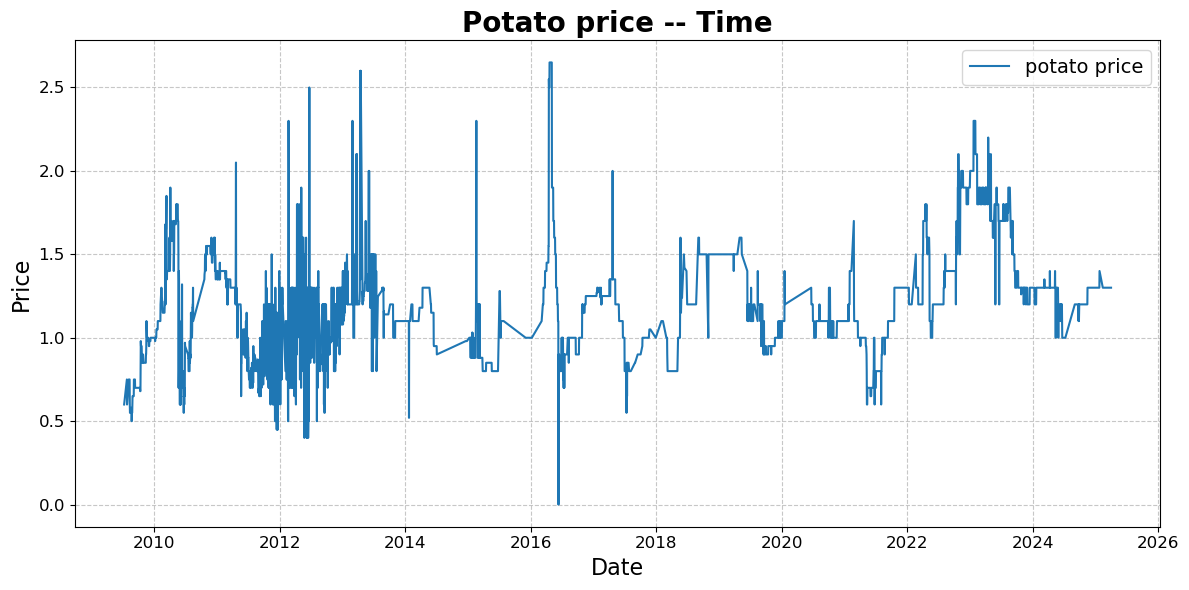

In [11]:
import matplotlib.pyplot as plt

# === 1. 中文字体和负号处理 ===
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 或 'Microsoft YaHei'
# plt.rcParams['axes.unicode_minus'] = False

# === 2. 开始绘图 ===
plt.figure(figsize=(12, 6))  # 画布大小，可以调大一点

# 举个例子：画蔬菜价格时间序列
plt.plot(df_potato['date'], df_potato['price'], label='potato price', color='tab:blue')

# === 3. 设置标题、标签、图例 ===
plt.title('Potato price -- Time', fontsize=20, fontweight='bold')   # 标题大且加粗
plt.xlabel('Date', fontsize=16)    # X轴标签
plt.ylabel('Price', fontsize=16) # Y轴标签

plt.xticks(fontsize=12)  # x轴刻度字体大小
plt.yticks(fontsize=12)  # y轴刻度字体大小

plt.grid(True, linestyle='--', alpha=0.7)  # 加网格线，虚线，透明度0.7

plt.legend(fontsize=14)  # 图例字号

# === 4. 展示图 ===
plt.tight_layout()  # 自动调整子图参数，防止标签被遮挡
plt.show()


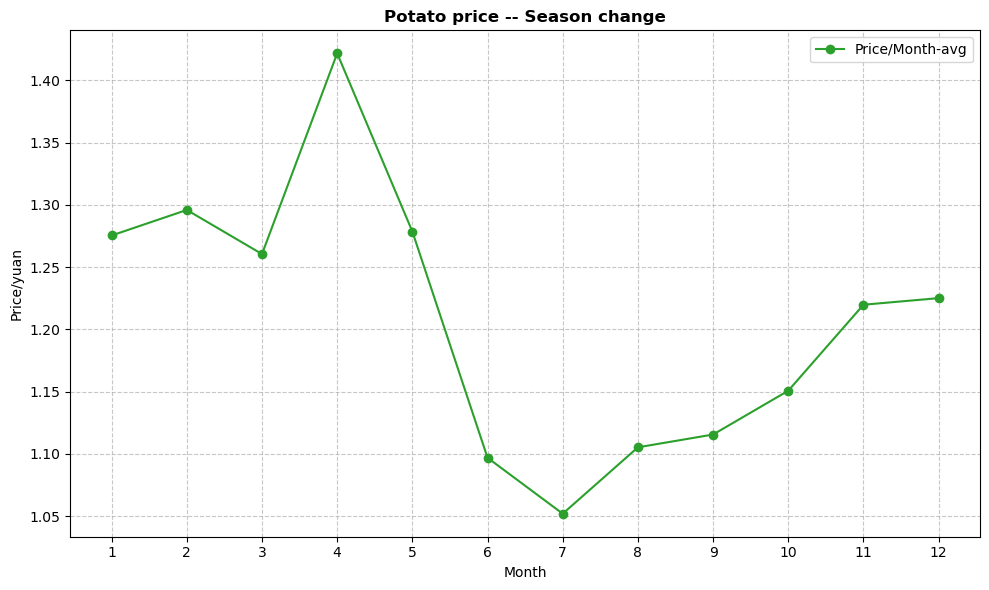

In [12]:
import matplotlib.pyplot as plt

# # 统一设置中文和样式
# plt.rcParams.update({
#     'font.sans-serif': ['SimHei'],   # 中文
#     'axes.unicode_minus': False,
#     'axes.titlesize': 20,
#     'axes.labelsize': 16,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12,
#     'legend.fontsize': 14,
# })

# === 1. 计算每个月的平均价格 ===
monthly_avg = df_potato.groupby('month')['price'].mean()

# === 2. 画出每个月的平均价格变化 ===
plt.figure(figsize=(10, 6))

plt.plot(monthly_avg.index, monthly_avg.values, marker='o', color='tab:green', label='Price/Month-avg')

plt.title('Potato price -- Season change', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Price/yuan')

plt.xticks(range(1, 13))  # 保证横轴是1-12月
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


# 土豆 真实-预测对比

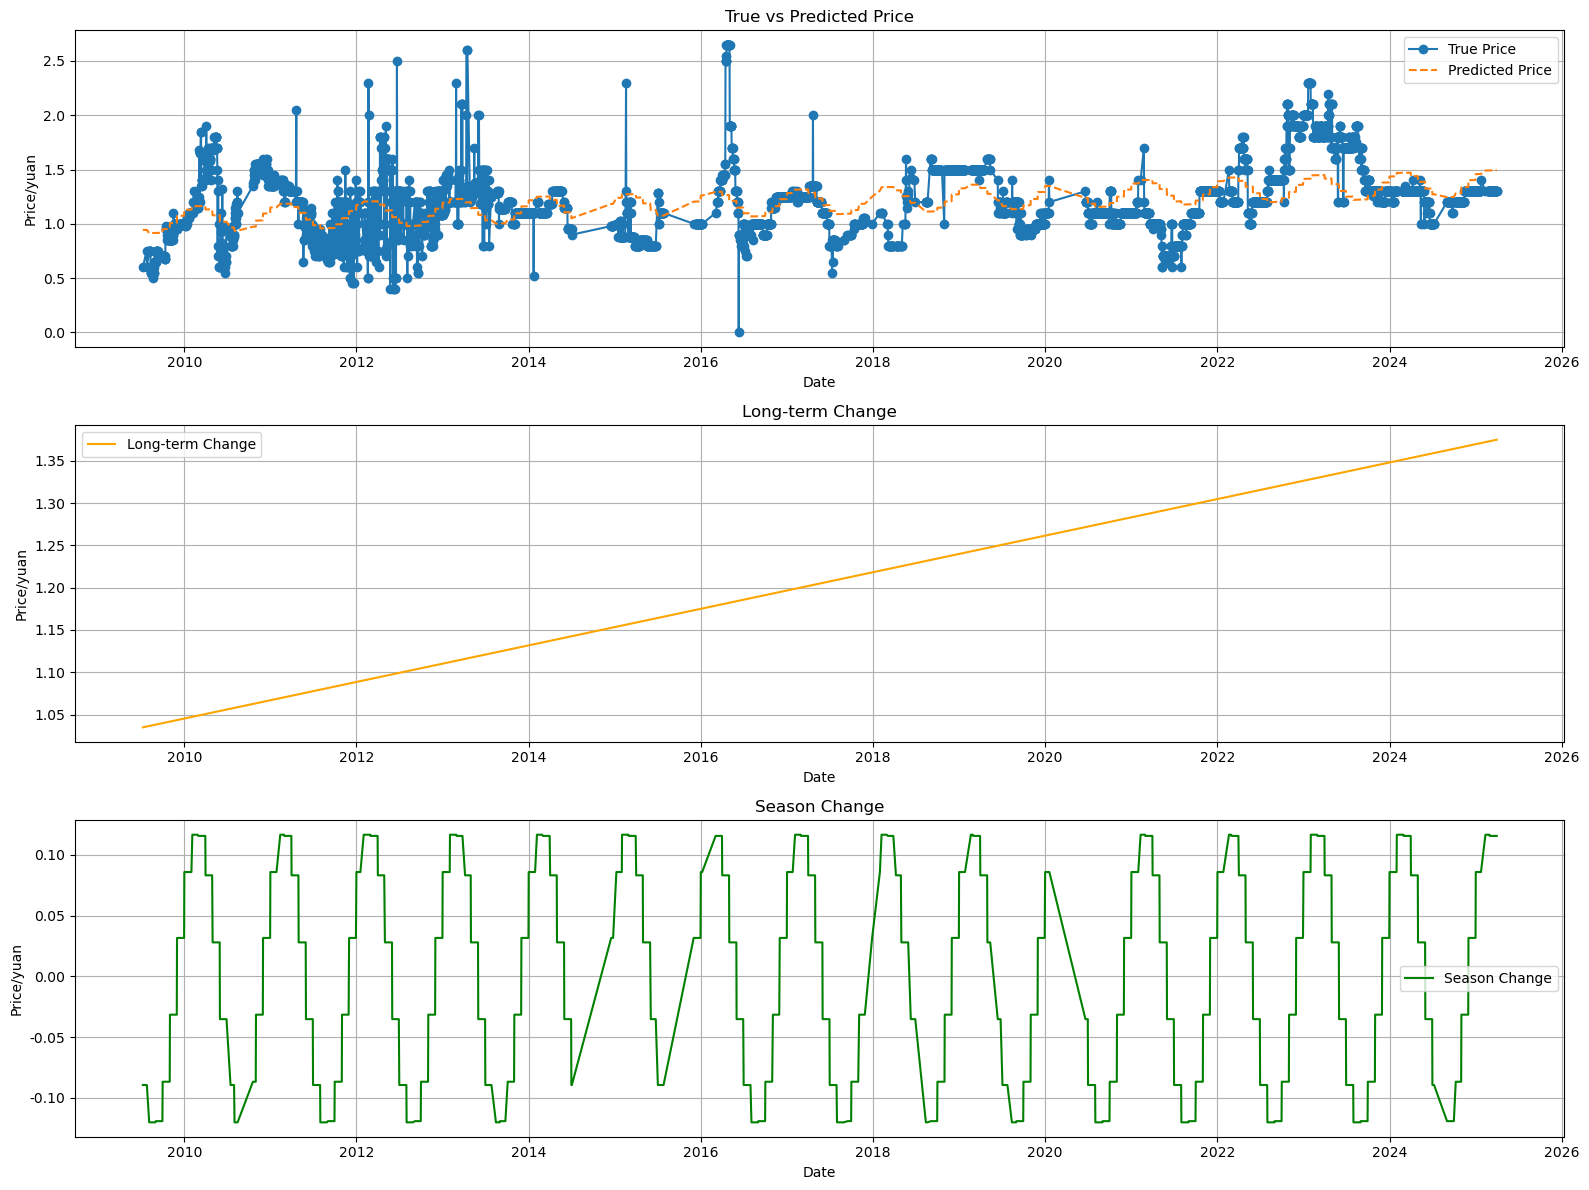

In [13]:
plt.figure(figsize=(16,12))

# 1. 真实价格 vs 整体预测
plt.subplot(3, 1, 1)
plt.plot(df_potato['date'], df_potato['price'], label='True Price', marker='o')
plt.plot(df_potato['date'], df_potato['price_pred'], label='Predicted Price', linestyle='--')
plt.title('True vs Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price/yuan')
plt.legend()
plt.grid(True)

# 2. 长期趋势部分
plt.subplot(3, 1, 2)
plt.plot(df_potato['date'], df_potato['trend_part'], color='orange', label='Long-term Change')
plt.title('Long-term Change')
plt.xlabel('Date')
plt.ylabel('Price/yuan')
plt.legend()
plt.grid(True)

# 3. 季节性变化部分
plt.subplot(3, 1, 3)
plt.plot(df_potato['date'], df_potato['season_part'], color='green', label='Season Change')
plt.title('Season Change')
plt.xlabel('Date')
plt.ylabel('Price/yuan')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 土豆测评

In [14]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y, df_potato['price_pred'])
mse = mean_squared_error(y, df_potato['price_pred'])
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")


R²: 0.1701
MSE: 0.0861


# 西红柿

In [15]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # === 1. 数据准备 & 处理缺失值 ===
# df_tomato = df[df['vegetable'] == '西红柿'].copy()
# df_tomato = df_tomato.sort_values('date').reset_index(drop=True)
# df_tomato.set_index('date', inplace=True)

# # 确保每日数据完整（填充缺失日期）
# tomato_daily = df_tomato['price'].resample('D').mean().ffill()  # 按天重采样并前向填充

# # 划分训练/测试集
# train = tomato_daily[tomato_daily.index < '2024-01-01']
# test = tomato_daily[(tomato_daily.index >= '2024-01-01') & 
#                     (tomato_daily.index < '2025-01-01')]

# print(f"训练集样本数: {len(train)} 天, 测试集样本数: {len(test)} 天")

# # === 2. 拟合 SARIMAX 模型 ===
# # 调整参数确保收敛
# model = SARIMAX(train,
#                 order=(1, 1, 1),
#                 seasonal_order=(1, 1, 1, 7),  # 7天季节性周期
#                 trend='c',
#                 enforce_stationarity=False,
#                 enforce_invertibility=False)

# # 增加迭代次数解决收敛问题
# res = model.fit(disp=True, maxiter=200)  # 显示优化过程信息

# # === 3. 生成预测 ===
# # 自动匹配测试集日期（无需手动设置索引）
# forecast_res = res.get_forecast(steps=len(test))
# pred = forecast_res.predicted_mean
# conf_int = forecast_res.conf_int()  # 获取置信区间

# # === 4. 可视化结果 ===
# plt.figure(figsize=(12, 5))

# # 绘制完整历史数据
# # plt.plot(tomato_daily.index, tomato_daily, color='gray', alpha=0.3, label='Full History')

# # # 绘制训练集拟合值
# # plt.plot(train.index, res.fittedvalues, color='green', linestyle=':', label='Train Fit')

# # 绘制测试集对比
# plt.plot(test.index, test, color='blue', label='Actual Price')
# plt.plot(pred.index, pred, color='red', linestyle='--', label='Forecast')

# # 添加置信区间
# # plt.fill_between(conf_int.index, 
# #                  conf_int.iloc[:, 0], 
# #                  conf_int.iloc[:, 1], 
# #                  color='pink', alpha=0.3, label='95% CI')

# plt.title('Tomato Price Forecasting with SARIMAX', fontsize=14)
# plt.xlabel('Date')
# plt.ylabel('Price (yuan)')
# plt.legend()
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# # === 5. 评估指标 ===
# # from sklearn.metrics import mean_absolute_error, mean_squared_error

# # mae = mean_absolute_error(test, pred)
# # rmse = np.sqrt(mean_squared_error(test, pred))

# # print(f"模型评估指标:\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}")

Epoch [10/20], Loss: 0.000437
Epoch [20/20], Loss: 0.000428
MAE: 0.12, RMSE: 0.21


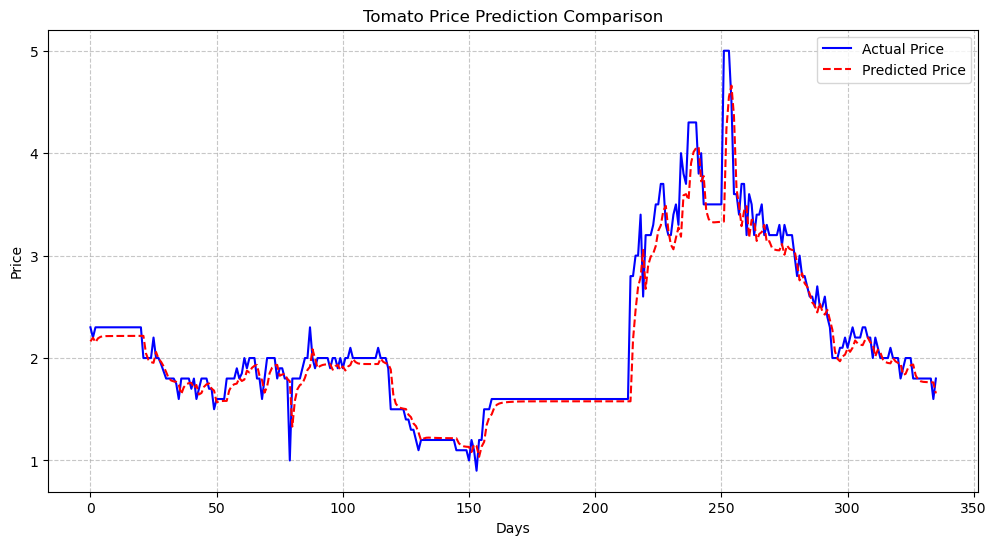

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# === 1. 数据准备 ===
# 加载数据（假设df已存在）
df_tomato = df[df['vegetable'] == '西红柿'].copy()
df_tomato = df_tomato.sort_values('date').reset_index(drop=True)
df_tomato.set_index('date', inplace=True)

# 处理缺失值并重采样
tomato_daily = df_tomato['price'].resample('D').mean().ffill()

# 划分数据集
train = tomato_daily[tomato_daily.index < '2024-01-01'].values.reshape(-1, 1)
test = tomato_daily[(tomato_daily.index >= '2024-01-01') & 
                   (tomato_daily.index < '2025-01-01')].values.reshape(-1, 1)

# 数据标准化
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# === 2. 创建时序数据集 ===
def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data)-window_size):
        seq = data[i:i+window_size]
        label = data[i+window_size]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

window_size = 30  # 使用过去30天预测下一天
X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

# 转换为PyTorch张量
X_train = torch.FloatTensor(X_train).squeeze(2)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test).squeeze(2)
y_test = torch.FloatTensor(y_test)

# === 3. 定义LSTM模型 ===
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x.unsqueeze(-1), (h0, c0))  # 添加特征维度
        out = self.fc(out[:, -1, :])  # 只取最后一个时间步的输出
        return out

# === 4. 训练配置 ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 20

# 创建DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# === 5. 训练过程 ===
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.6f}')

# === 6. 预测与评估 ===
model.eval()
with torch.no_grad():
    test_inputs = X_test.to(device)
    preds = model(test_inputs).cpu().numpy()

# 逆标准化
true_predictions = scaler.inverse_transform(preds)
y_test_actual = scaler.inverse_transform(y_test.numpy())

# 计算指标
mae = np.mean(np.abs(true_predictions - y_test_actual))
rmse = np.sqrt(np.mean((true_predictions - y_test_actual)**2))
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# === 7. 可视化结果 ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(true_predictions, label='Predicted Price', color='red', linestyle='--')
plt.title('Tomato Price Prediction Comparison')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

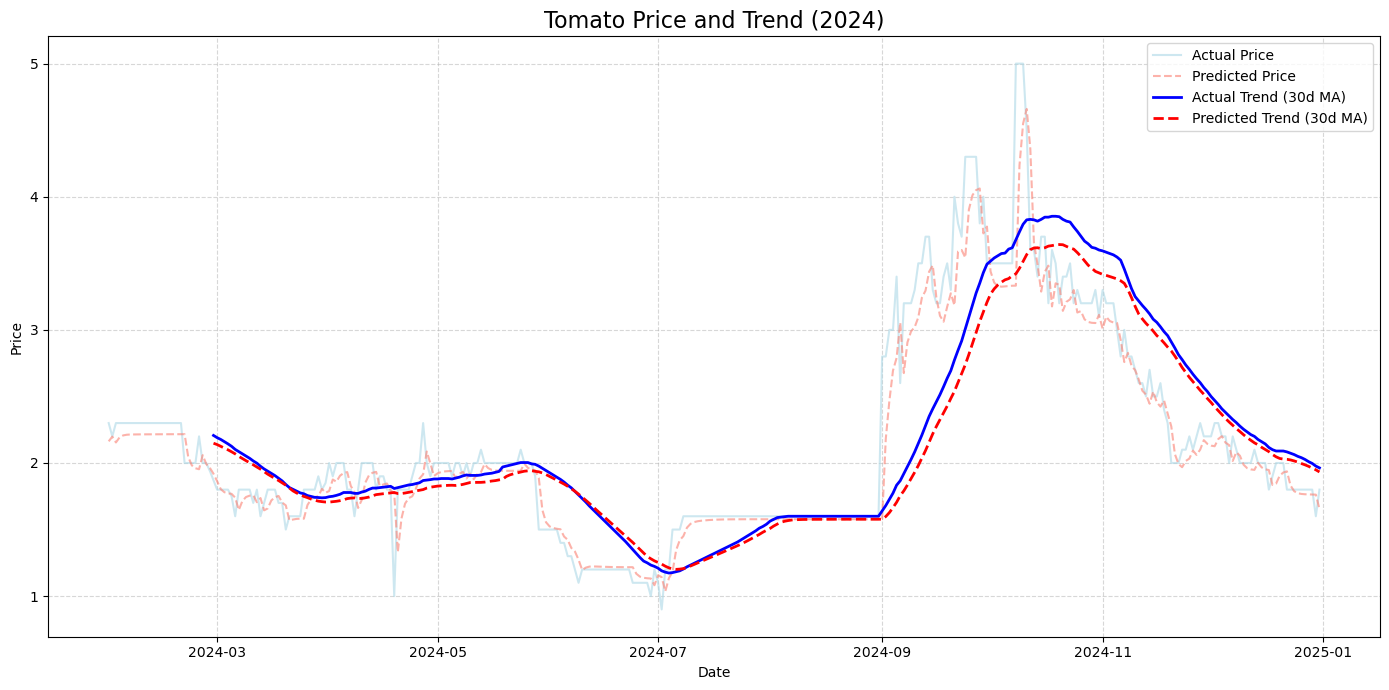


【实际价格变化】2024年价格变化率：-21.74%
【预测价格变化】2024年预测价格变化率：-23.48%
实际趋势方向：下降
预测趋势方向：下降


In [33]:
# === 8. 趋势分析 ===

# 8.1 把真实值和预测值都变成时间序列
# 创建对应的时间索引
test_dates = tomato_daily[(tomato_daily.index >= '2024-01-01') & 
                          (tomato_daily.index < '2025-01-01')].index[window_size:]  # 注意要对齐window_size

# 构建Series
actual_series = pd.Series(y_test_actual.flatten(), index=test_dates)
predicted_series = pd.Series(true_predictions.flatten(), index=test_dates)

# 8.2 绘制滑动平均趋势
rolling_window = 30  # 30天滑动平均
actual_trend = actual_series.rolling(window=rolling_window).mean()
predicted_trend = predicted_series.rolling(window=rolling_window).mean()

# 8.3 绘制趋势对比图
plt.figure(figsize=(14, 7))
plt.plot(actual_series, label='Actual Price', color='lightblue', alpha=0.6)
plt.plot(predicted_series, label='Predicted Price', color='salmon', linestyle='--', alpha=0.6)
plt.plot(actual_trend, label='Actual Trend (30d MA)', color='blue', linewidth=2)
plt.plot(predicted_trend, label='Predicted Trend (30d MA)', color='red', linestyle='--', linewidth=2)

plt.title('Tomato Price and Trend (2024)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 9. 趋势分析结论输出 ===

# 9.1 计算整体涨跌幅
actual_change = (actual_series.iloc[-1] - actual_series.iloc[0]) / actual_series.iloc[0] * 100
predicted_change = (predicted_series.iloc[-1] - predicted_series.iloc[0]) / predicted_series.iloc[0] * 100

print(f"\n【实际价格变化】2024年价格变化率：{actual_change:.2f}%")
print(f"【预测价格变化】2024年预测价格变化率：{predicted_change:.2f}%")

# 9.2 趋势方向判定
def determine_trend(change):
    if change > 2:
        return '上升'
    elif change < -2:
        return '下降'
    else:
        return '基本持平'

actual_trend_direction = determine_trend(actual_change)
predicted_trend_direction = determine_trend(predicted_change)

print(f"实际趋势方向：{actual_trend_direction}")
print(f"预测趋势方向：{predicted_trend_direction}")


In [ ]:
# # === 6.5 新增未来预测函数 ===
# def forecast_future(model, initial_sequence, steps, device):
#     model.eval()
#     predictions = []
#     current_sequence = initial_sequence.clone().to(device)
    
#     with torch.no_grad():
#         for _ in range(steps):
#             # 预测下一个时间步
#             pred = model(current_sequence.unsqueeze(0))  # 添加batch维度
#             predictions.append(pred.cpu().numpy()[0,0])
            
#             # 更新序列：移除第一个元素，添加预测值
#             current_sequence = torch.cat(
#                 (current_sequence[1:], pred.view(1)))
    
#     return np.array(predictions)

# # === 6.6 执行未来预测 ===
# # 获取测试集最后window_size的数据作为初始输入
# last_sequence = test_scaled[-window_size:].reshape(1, window_size, 1)
# last_sequence = torch.FloatTensor(last_sequence).to(device)

# # 预测未来365天
# future_steps = 365
# future_pred_scaled = forecast_future(model, last_sequence, future_steps, device)

# # 逆标准化
# future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1))

# # 生成未来日期索引
# last_date = tomato_daily.index[-1]
# future_dates = pd.date_range(
#     start=last_date + pd.Timedelta(days=1), 
#     periods=future_steps,
#     freq='D'
# )

# # === 7. 修改可视化部分 ===
# plt.figure(figsize=(15, 7))

# # 绘制历史实际数据
# plt.plot(tomato_daily.index, tomato_daily.values, 
#         label='Historical Price', color='gray', alpha=0.7)

# # 绘制测试集预测结果
# plt.plot(pred_dates, y_test_actual, 
#         label='Test Actual', color='blue', linewidth=2)
# plt.plot(pred_dates, true_predictions, 
#         label='Test Predictions', color='green', linestyle='--')

# # 绘制未来预测
# plt.plot(future_dates, future_pred, 
#         label='Future Forecast', color='red', linewidth=2)
# plt.fill_between(future_dates, 
#                  future_pred.flatten()*0.95,  # 添加误差带示例
#                  future_pred.flatten()*1.05,
#                  color='red', alpha=0.1)

# # 美化图形
# plt.title('Tomato Price Forecast: Historical, Test and Future', fontsize=14)
# plt.xlabel('Date')
# plt.ylabel('Price (yuan)')
# plt.legend(loc='upper left')

# # 设置日期格式
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.gcf().autofmt_xdate()

# # 限制显示范围
# plt.xlim([tomato_daily.index[-150], future_dates[-1]])

# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

ValueError: LSTM: Expected input to be 2D or 3D, got 5D instead

In [24]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y_test_actual, true_predictions)
mse = mean_squared_error(y_test_actual, true_predictions)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")

R²: 0.9286
MSE: 0.0436


In [ ]:
# 先处理数据
df_tomato = df[df['vegetable'] == '西红柿'].copy()
df_tomato = df_tomato.sort_values('date').reset_index(drop=True)

# 加特征
df_tomato['days_since_start'] = (df_tomato['date'] - df_tomato['date'].min()).dt.days
df_tomato['sin_month'] = np.sin(2 * np.pi * df_tomato['month'] / 12)
df_tomato['cos_month'] = np.cos(2 * np.pi * df_tomato['month'] / 12)

# 建模
X = df_tomato[['days_since_start', 'sin_month', 'cos_month']]
y = df_tomato['price']

model = LinearRegression()
model.fit(X, y)

# 预测整体
df_tomato['price_pred'] = model.predict(X)

# 预测长期趋势部分（只用 days_since_start）
trend_model = LinearRegression()
trend_model.fit(df_tomato[['days_since_start']], y)
df_tomato['trend_part'] = trend_model.predict(df_tomato[['days_since_start']])

# 预测季节性变化部分（只用 sin_month 和 cos_month）
season_model = LinearRegression()
season_model.fit(df_tomato[['sin_month', 'cos_month']], y - df_tomato['trend_part'])
df_tomato['season_part'] = season_model.predict(df_tomato[['sin_month', 'cos_month']])


# 西红柿画图

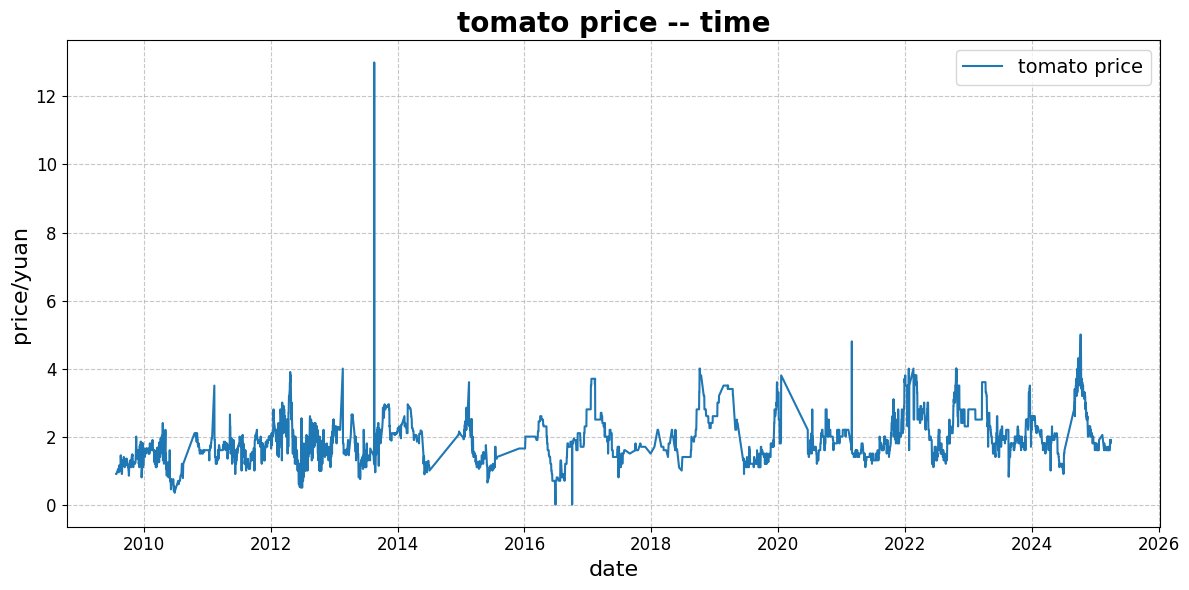

In [ ]:
import matplotlib.pyplot as plt

# # === 1. 中文字体和负号处理 ===
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 或 'Microsoft YaHei'
# plt.rcParams['axes.unicode_minus'] = False

# === 2. 开始绘图 ===
plt.figure(figsize=(12, 6))  # 画布大小，可以调大一点

# 举个例子：画蔬菜价格时间序列
plt.plot(df_tomato['date'], df_tomato['price'], label='tomato price', color='tab:blue')

# === 3. 设置标题、标签、图例 ===
plt.title('tomato price -- time', fontsize=20, fontweight='bold')   # 标题大且加粗
plt.xlabel('date', fontsize=16)    # X轴标签
plt.ylabel('price/yuan', fontsize=16) # Y轴标签

plt.xticks(fontsize=12)  # x轴刻度字体大小
plt.yticks(fontsize=12)  # y轴刻度字体大小

plt.grid(True, linestyle='--', alpha=0.7)  # 加网格线，虚线，透明度0.7

plt.legend(fontsize=14)  # 图例字号

# === 4. 展示图 ===
plt.tight_layout()  # 自动调整子图参数，防止标签被遮挡
plt.show()


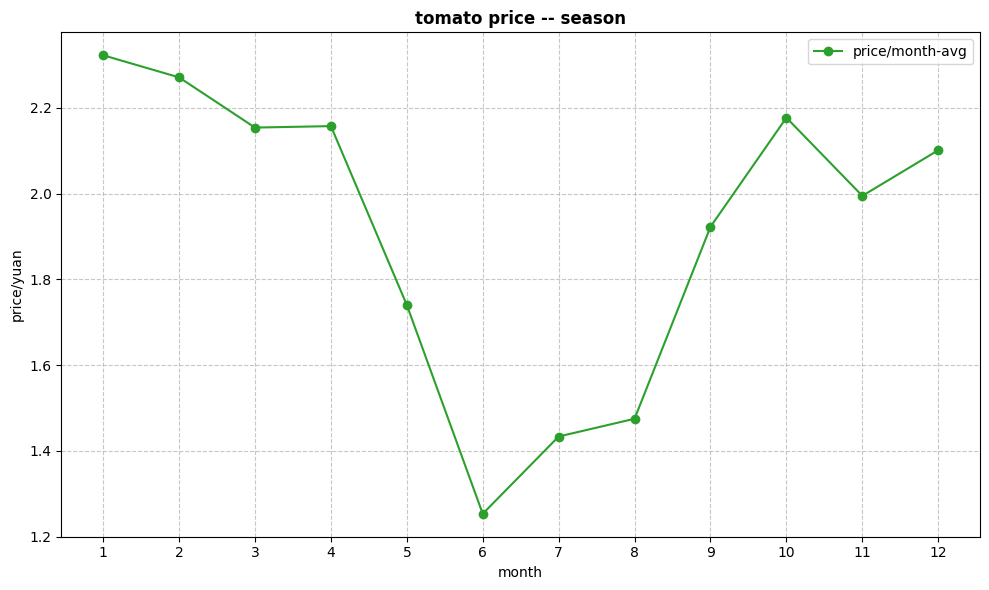

In [ ]:
import matplotlib.pyplot as plt

# # 统一设置中文和样式
# plt.rcParams.update({
#     'font.sans-serif': ['SimHei'],   # 中文
#     'axes.unicode_minus': False,
#     'axes.titlesize': 20,
#     'axes.labelsize': 16,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12,
#     'legend.fontsize': 14,
# })

# === 1. 计算每个月的平均价格 ===
monthly_avg = df_tomato.groupby('month')['price'].mean()

# === 2. 画出每个月的平均价格变化 ===
plt.figure(figsize=(10, 6))

plt.plot(monthly_avg.index, monthly_avg.values, marker='o', color='tab:green', label='price/month-avg')

plt.title('tomato price -- season', fontweight='bold')
plt.xlabel('month')
plt.ylabel('price/yuan')

plt.xticks(range(1, 13))  # 保证横轴是1-12月
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


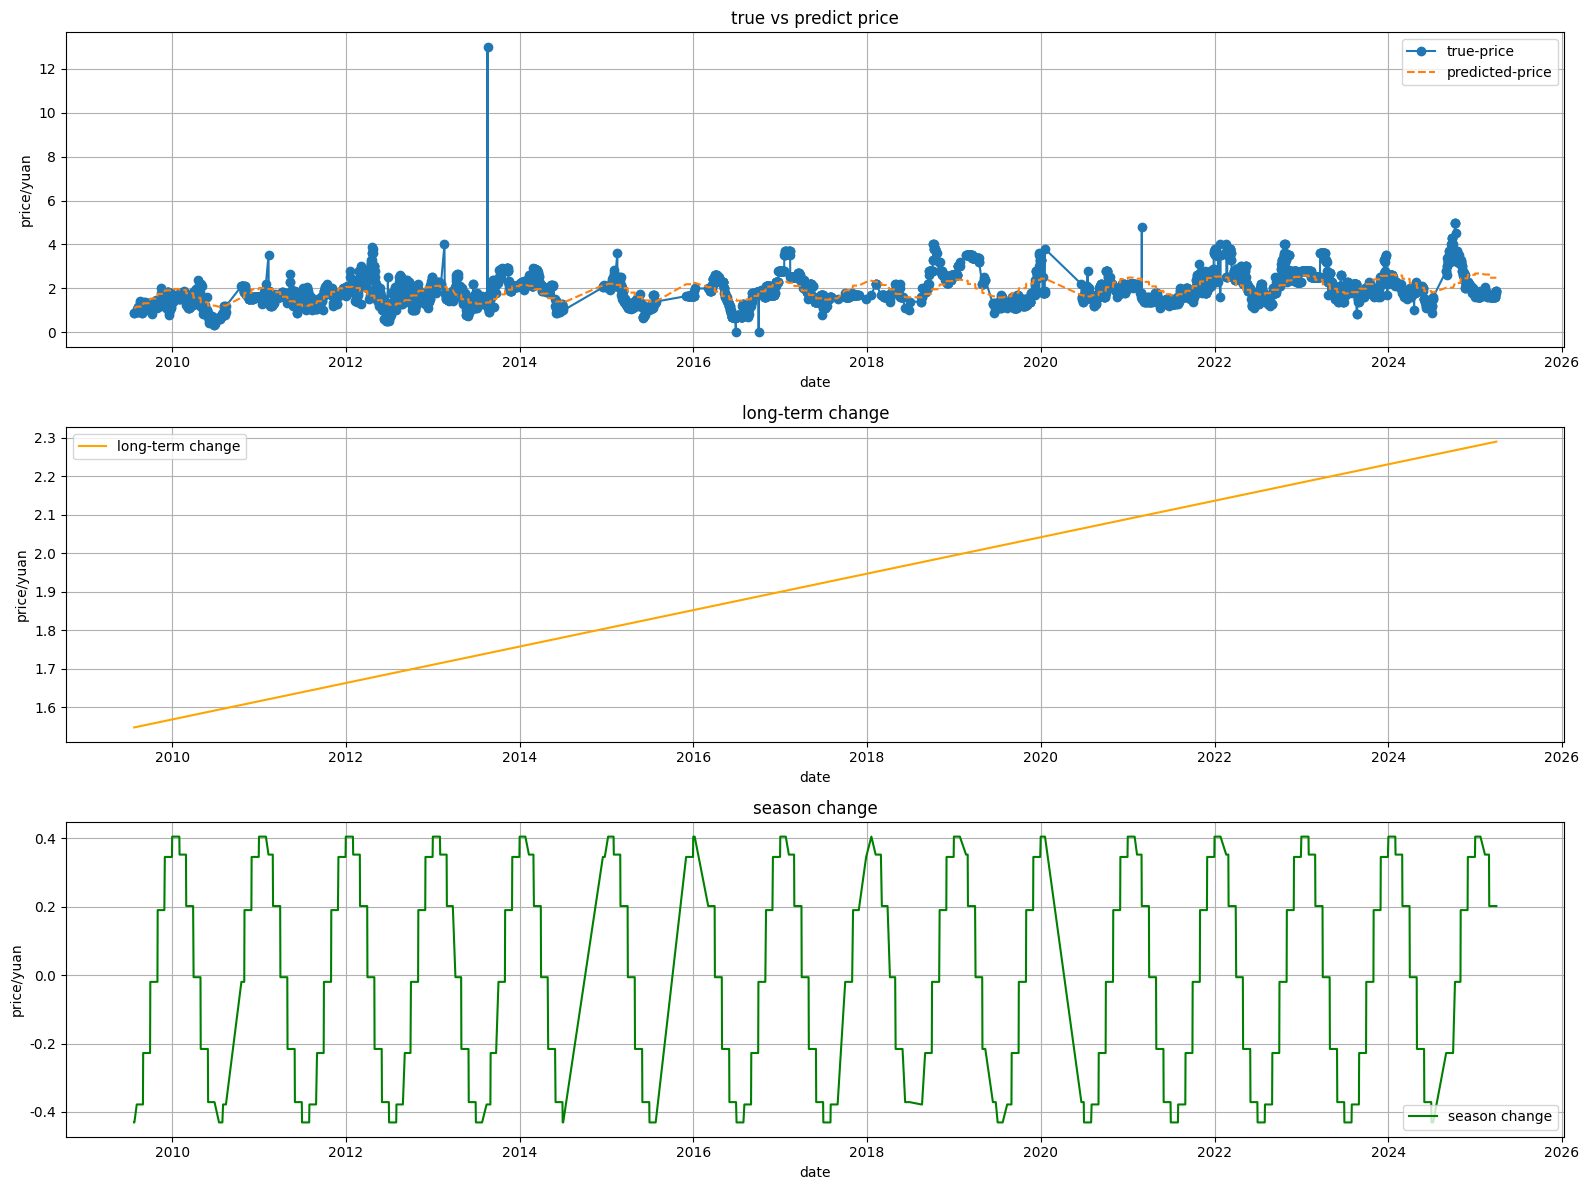

In [ ]:
plt.figure(figsize=(16,12))

# 1. 真实价格 vs 整体预测
plt.subplot(3, 1, 1)
plt.plot(df_tomato['date'], df_tomato['price'], label='true-price', marker='o')
plt.plot(df_tomato['date'], df_tomato['price_pred'], label='predicted-price', linestyle='--')
plt.title('true vs predict price')
plt.xlabel('date')
plt.ylabel('price/yuan')
plt.legend()
plt.grid(True)

# 2. 长期趋势部分
plt.subplot(3, 1, 2)
plt.plot(df_tomato['date'], df_tomato['trend_part'], color='orange', label='long-term change')
plt.title('long-term change')
plt.xlabel('date')
plt.ylabel('price/yuan')
plt.legend()
plt.grid(True)

# 3. 季节性变化部分
plt.subplot(3, 1, 3)
plt.plot(df_tomato['date'], df_tomato['season_part'], color='green', label='season change')
plt.title('season change')
plt.xlabel('date')
plt.ylabel('price/yuan')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# 西红柿测评

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(y, df_tomato['price_pred'])
mse = mean_squared_error(y, df_tomato['price_pred'])
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")


R²: 0.2876
MSE: 0.3343
